In [44]:
# 第一种预测方法（在时间连续的情况下）
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn.metrics import make_scorer

In [45]:
# 预处理输入数据
def preprocessing(nmp_df,power_df):
    print('Date of his_weather:',nmp_df.head(10))
    print('Date of his_power:',power_df.head(10))
    fix_df=pd.merge(nmp_df, power_df, on=['Datetime'], how='left')
    print(fix_df.head(10))
    print(fix_df.describe())
    return fix_df

In [46]:
# 读取数据
his_nmp_fd_df = pd.read_csv('03 His_NWP_GF.CSV',parse_dates=["Datetime"],index_col=[0])
his_power_fd_df = pd.read_csv('02 His_Power_GF.CSV',parse_dates=["Datetime"],index_col=[0])
his_fd_df=preprocessing(his_nmp_fd_df,his_power_fd_df)
his_fd_df.to_csv('his_df.csv',encoding = 'utf-8') #存储合并后数据
df=pd.read_csv('his_df.csv',parse_dates=["Datetime"],index_col=[0])

Date of his_weather:                      TemperH  TemperJ  TemperO   Flow
Datetime                                             
2022-06-13 00:00:00      0.0   6.9614  14.8148  27.32
2022-06-13 00:15:00      0.0   7.0349  15.1623  27.33
2022-06-13 00:30:00      0.0   7.1234  14.3874  27.31
2022-06-13 00:45:00      0.0   7.2816  15.6968  27.29
2022-06-13 01:00:00      0.0   7.2544  18.7347  27.34
2022-06-13 01:15:00      0.0   7.1066  21.5469  27.38
2022-06-13 01:30:00      0.0   7.0586  22.3139  27.38
2022-06-13 01:45:00      0.0   7.0380  23.1772  27.38
2022-06-13 02:00:00      0.0   6.9662  24.8728  27.39
2022-06-13 02:15:00      0.0   6.9710  24.7637  27.41
Date of his_power:                      Lifetime
Datetime                     
2022-06-13 00:00:00      5.00
2022-06-13 00:15:00      5.01
2022-06-13 00:30:00      5.02
2022-06-13 00:45:00      5.03
2022-06-13 01:00:00      5.04
2022-06-13 01:15:00      5.05
2022-06-13 01:30:00      5.06
2022-06-13 01:45:00      5.07
2022-06-13 0

In [47]:
# 划分train valid test集
fd_df_train = df[:int(0.6*len(df))]
fd_df_valid = df[int(0.6*len(df)):int(0.8*len(df))]
fd_df_test =df[int(0.8*len(df)):]

In [48]:
# 对数据进行归一化处理
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df)
df_for_training_scaled = scaler.transform(fd_df_train)
df_for_validing_scaled=scaler.transform(fd_df_valid)
df_for_testing_scaled=scaler.transform(fd_df_test)
df_scaled=scaler.transform(df)

In [49]:
# 分离x与y
def createXY(array, days_used_to_train=7):
    features = list()
    labels = list()

    for i in range(days_used_to_train, len(array)):
        features.append(array[i-days_used_to_train:i, :])
        labels.append(array[i, -1])
    return np.array(features), np.array(labels)

train_X,train_y=createXY(df_for_training_scaled)
valid_X,valid_y=createXY(df_for_validing_scaled)
test_X,test_y=createXY(df_for_testing_scaled)
df_scaled_X,df_scaled_y=createXY(df_scaled)

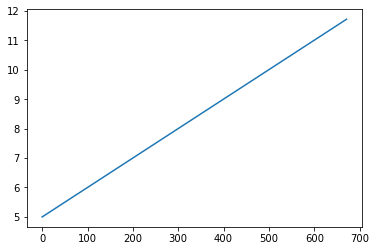

In [50]:
# 看一下历史波形
plt.plot(range(len(df['Lifetime'])), df['Lifetime'], label='history')
# 定义一个新的评价函数
def ev(y_true, y_predict):
    difference=((np.array(y_true) - np.array(y_predict.flatten()))**2).sum()
    return float(difference) 
    from sklearn.metrics import make_scorer
my_scorer = make_scorer(ev, greater_is_better=False) 
scoring = {
    'ev': my_scorer
}

In [51]:
# 建立模型函数
def build_model(size):
    tf.random.set_seed(1) #设置随机数种子
    # Create grid_model
    grid_model = tf.keras.Sequential()
    grid_model.add(tf.keras.layers.LSTM(units=64))
    grid_model.add(tf.keras.layers.Dense(64))
    grid_model.add(tf.keras.layers.Dense(size))
    grid_model.add(tf.keras.layers.Dense(1))

    # Compile the grid_model
    grid_model.compile(
    optimizer='adam',
    loss='mse')

    return grid_model
    from keras.wrappers.scikit_learn import KerasClassifier
grid_model = KerasRegressor(build_fn=build_model)
parameters = {'batch_size' : [16],'epochs' : [40],'size' : [32]}
grid_search = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            scoring=scoring, 
                            refit ='ev', 
                            n_jobs=1,
                            cv = 2)
grid_search = grid_search.fit(train_X, train_y,validation_data=(valid_X, valid_y))

C:\Users\曹瑜\AppData\Local\Temp\ipykernel_26740\1534772476.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model)


Epoch 1/40
13/13 [==============================] - 6s 92ms/step - loss: 0.0692 - val_loss: 0.0049
Epoch 2/40
13/13 [==============================] - 0s 14ms/step - loss: 0.0073 - val_loss: 0.0200
Epoch 3/40
13/13 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.0129
Epoch 4/40
13/13 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0102
Epoch 5/40
13/13 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0175
Epoch 6/40
13/13 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0060
Epoch 7/40
13/13 [==============================] - 0s 14ms/step - loss: 9.8616e-04 - val_loss: 0.0076
Epoch 8/40
13/13 [==============================] - 0s 11ms/step - loss: 6.6850e-04 - val_loss: 0.0073
Epoch 9/40
13/13 [==============================] - 0s 12ms/step - loss: 5.0611e-04 - val_loss: 0.0046
Epoch 10/40
13/13 [==============================] - 0s 13ms/step - loss: 3.5808e-04 - val_loss: 

In [53]:
# 输出最佳模型为my_model
my_model=grid_search.best_estimator_.model
    # 预测未来
# 从past数据中抽取7组作为未来数据的开头
df_30_days_past=df.iloc[-7:,:]
# 提取未来数据
df_30_days_future=pd.read_csv('04 Fore_NWP_GF.CSV',parse_dates=["Datetime"],index_col=[0])
df_30_days_future.shape
df_30_days_future["Lifetime"]=0 # 为方便后续操作，为未来数据添加一power列
# 归一化过去数据
old_scaled_array=scaler.transform(df_30_days_past)
# 归一化未来数据
new_scaled_array=scaler.transform(df_30_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,-1]=np.nan #将未来数据表中power转为NaN
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1) #合并表格

In [54]:
# 开始逐点预测
full_df_scaled_array=full_df.values
all_data=[]
time_step=7
for i in range(time_step,len(full_df_scaled_array)):
        data_x=[]
        data_x.append( full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
        data_x=np.array(data_x)
        prediction=my_model.predict(data_x)
        if prediction<0:
            prediction=0
        all_data.append(prediction)
        full_df.iloc[i,-1]=prediction
all_data=np.array(all_data).flatten()

1/1 [==============================] - 0s 27ms/step


In [56]:
# 反归一化操作
df_fin=pd.read_csv('04 Fore_NWP_GF.CSV',parse_dates=["Datetime"],index_col=[0])
len(df_fin)
df_fin['Lifetime']=0
df_fin['Lifetime']=all_data
df_fin
predicted_data = scaler.inverse_transform(df_fin)
fd_time=pd.read_csv('YC_Result_GF.CSV')
fd_time['Lifetime']=predicted_data[:,-1]
fd_time.to_csv('feature_gf_power.csv',index=0)
fd_time.to_excel('feature_gf_power.xlsx',index=0)
# print('success1')
fpath = '.\\feature_gf_power.xlsx'

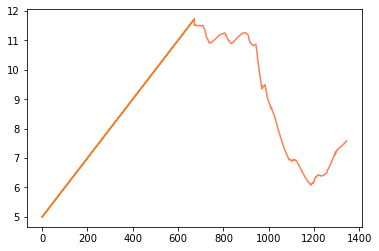

In [57]:
#绘制反归一化后整体发电量图
retotal = np.hstack((df['Lifetime'],predicted_data[:,-1]))
plt.plot(range(len(df['Lifetime'])), df['Lifetime'], label='Prediction')
plt.plot(range(len(retotal)), retotal, label='Prediction',color='coral')
plt.plot(range(len(df['Lifetime'])), df['Lifetime'], label='Prediction')